In [1]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

df = pd.read_csv(file_path, parse_dates=['Time'])

df = df.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
df.head()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volume,VPIN,CDF,Roll,...,Kurtosis,JB_rolling,JB_ChangeSign,AR,AR_ChangeSign,SkewnessSign,KurtosisSign,MA_20,MA_50,MASign
0,2025-09-05 21:11:22+00:00,75.345578,155.654422,111484.679703,111514.287737,111470.347733,231.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,2025-09-05 21:16:50+00:00,86.968079,144.031921,110875.575754,110820.425595,110908.876035,231.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,2025-09-05 21:17:30+00:00,119.562076,111.437924,110582.227772,110587.940420,110576.098656,231.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2025-09-05 21:23:22+00:00,99.500447,131.499553,110990.803219,110984.286267,110995.734335,231.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,2025-09-05 21:35:39+00:00,105.266120,125.733880,110897.116795,110911.971289,110884.680410,231.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_11979/4188677577.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  price15 = df['Price'].resample(rule).last()
/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_11979/4188677577.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  vpin15  = df['VPIN'].resample(rule).mean()


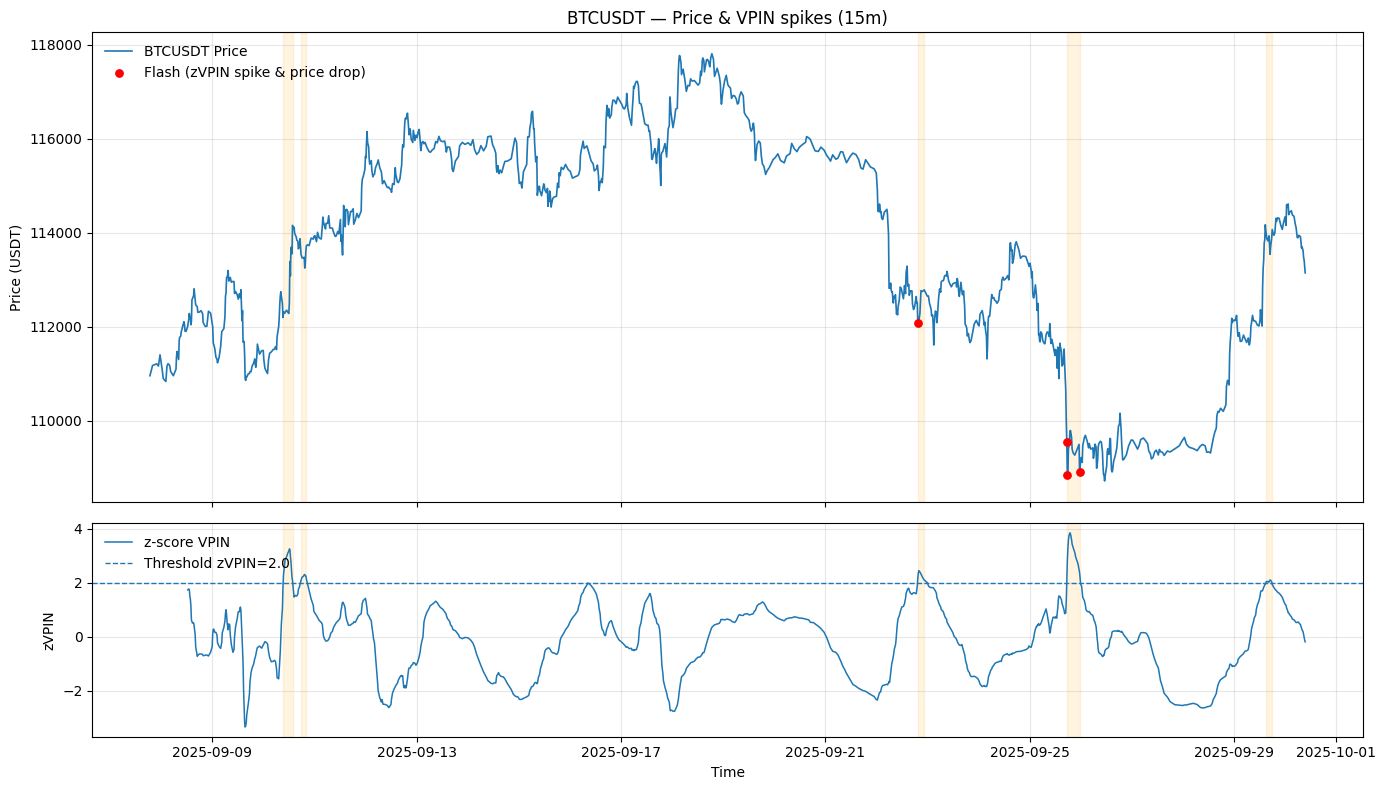

In [4]:

df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').dropna(subset=['Price','VPIN'])

# ==== RESAMPLE 15 PHÚT ====
df = df.set_index('Time')
rule = '15T'
price15 = df['Price'].resample(rule).last()
vpin15  = df['VPIN'].resample(rule).mean()
plotdf = pd.DataFrame({'Price': price15, 'VPIN': vpin15}).dropna()

# ==== LÀM MƯỢT & CHUẨN HOÁ VPIN ====
plotdf['VPIN_EMA'] = plotdf['VPIN'].ewm(span=8, adjust=False).mean()
z_win = 96
mu = plotdf['VPIN_EMA'].rolling(z_win, min_periods=30).mean()
sd = plotdf['VPIN_EMA'].rolling(z_win, min_periods=30).std()
plotdf['zVPIN'] = (plotdf['VPIN_EMA'] - mu) / sd

# ==== RETURN & NGƯỠNG CRASH ====
plotdf['ret15'] = plotdf['Price'].pct_change()
ret_win = 96
ret_sd = plotdf['ret15'].rolling(ret_win, min_periods=30).std()
Z_THR = 2.0
K = 1.5
plotdf['is_flash'] = (plotdf['zVPIN'] > Z_THR) & (plotdf['ret15'] < -(K * ret_sd))

# ==== VÙNG SPIKE ====
spike_mask = plotdf['zVPIN'] > Z_THR
# ✅ Tách phần này ra để tránh lỗi syntax
ranges = [(g.index[0], g.index[-1]) 
          for _, g in plotdf[spike_mask].groupby((~spike_mask).cumsum()) 
          if g.shape[0] > 0]

# ==== VẼ ====
fig, (ax_price, ax_vpin) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                                         gridspec_kw={'height_ratios':[2.2,1]})

# --- Giá ---
ax_price.plot(plotdf.index, plotdf['Price'], label='BTCUSDT Price', linewidth=1.2)
ax_price.scatter(plotdf.index[plotdf['is_flash']],
                 plotdf['Price'][plotdf['is_flash']],
                 s=28, color='red', label='Flash (zVPIN spike & price drop)', zorder=3)
# Highlight vùng zVPIN > Z_THR
for start, end in ranges:
    ax_price.axvspan(start, end, alpha=0.12, color='orange')

ax_price.set_ylabel('Price (USDT)')
ax_price.grid(alpha=0.3)
ax_price.legend(loc='upper left', frameon=False)
ax_price.set_title('BTCUSDT — Price & VPIN spikes (15m)')

# --- VPIN ---
ax_vpin.plot(plotdf.index, plotdf['zVPIN'], linewidth=1.1, label='z-score VPIN')
ax_vpin.axhline(Z_THR, linestyle='--', linewidth=1, label=f'Threshold zVPIN={Z_THR}')
for start, end in ranges:
    ax_vpin.axvspan(start, end, alpha=0.12, color='orange')
ax_vpin.set_ylabel('zVPIN')
ax_vpin.grid(alpha=0.3)
ax_vpin.legend(loc='upper left', frameon=False)

plt.xlabel('Time')
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np

def build_flash_labels(
    df,            # DataFrame có Time, Price, VPIN
    rule='15T',    # khung thời gian
    win=96,        # cửa sổ ước lượng σ (≈ 24h nếu 15m)
    ema_span=8,    # làm mượt VPIN
    Z_drop=3.0,    # ngưỡng rơi giá
    Z_vpin=2.0,    # ngưỡng zVPIN
    require_vpin=True,   # bắt buộc VPIN cao?
    horizon=2,     # số nến cảnh báo sớm trước event start
    cooldown=2     # số nến “nghỉ” để tách 2 event gần nhau
):
    x = df.copy()
    x['Time'] = pd.to_datetime(x['Time'], utc=True, errors='coerce')
    x = x.sort_values('Time').dropna(subset=['Time','Price','VPIN']).set_index('Time')

    # Resample
    price = x['Price'].resample(rule).last()
    vpin  = x['VPIN'].resample(rule).mean()
    X = pd.DataFrame({'Price': price, 'VPIN': vpin}).dropna()

    # Returns & σ (chỉ quá khứ)
    X['logP']  = np.log(X['Price'])
    X['ret']   = X['logP'].diff()
    X['vol']   = X['ret'].rolling(win, min_periods=max(20,int(win/4))).std()

    # zVPIN (EMA -> z-score) – chỉ quá khứ
    X['VPIN_EMA'] = X['VPIN'].ewm(span=ema_span, adjust=False).mean()
    mu = X['VPIN_EMA'].rolling(win, min_periods=max(20,int(win/4))).mean()
    sd = X['VPIN_EMA'].rolling(win, min_periods=max(20,int(win/4))).std()
    X['zVPIN'] = (X['VPIN_EMA'] - mu) / sd

    # Điều kiện event
    cond_drop = X['ret'] < -(Z_drop * X['vol'])
    cond_vpin = X['zVPIN'] > Z_vpin
    if require_vpin:
        cond_event = cond_drop & cond_vpin
    else:
        cond_event = cond_drop

    # Gộp thành event_id
    grp = (cond_event != cond_event.shift(1)).cumsum()
    X['event_id'] = np.where(cond_event, grp, np.nan)

    # Làm “cooldown” để tránh dính các cụm gần nhau
    if cooldown and cooldown > 0:
        # biến thời gian từ False->True là bắt đầu event
        starts = X.index[cond_event & ~cond_event.shift(1).fillna(False)]
        for s in starts:
            # tắt cond_event trong [end+1, end+cooldown]
            # tìm end của cụm
            mask = (X.index >= s) & cond_event
            end_idx = X.index[mask][-1]
            cool_slice = (X.index > end_idx) & (X.index <= end_idx + (pd.Timedelta(rule) * cooldown))
            cond_event.loc[cool_slice] = False
        grp = (cond_event != cond_event.shift(1)).cumsum()
        X['event_id'] = np.where(cond_event, grp, np.nan)

    # Bảng event summary
    events = []
    for eid, g in X.groupby('event_id'):
        if np.isnan(eid): 
            continue
        start, end = g.index[0], g.index[-1]
        sev = float((g['ret'].abs() / X.loc[g.index, 'vol']).max())
        sev_vpin = float(g['zVPIN'].max())
        events.append({'event_id': int(eid), 'start': start, 'end': end,
                       'severity_ret_sigma': sev, 'max_zVPIN': sev_vpin})
    events = pd.DataFrame(events)

    # Labels
    X['label_now'] = cond_event.astype(int)

    # Early-warning: 1 nếu thời điểm t nằm trong [start-horizon*Δ, start)
    X['label_ew'] = 0
    if not events.empty:
        step = pd.Timedelta(rule)
        warn = pd.Series(0, index=X.index)
        for _, row in events.iterrows():
            w_start = row['start'] - step * horizon
            warn.loc[(X.index >= w_start) & (X.index < row['start'])] = 1
        X['label_ew'] = warn.values

    return X, events


In [6]:
labels, ev = build_flash_labels(df, rule='15T', win=96, Z_drop=3.0, Z_vpin=2.0,
                                require_vpin=True, horizon=2, cooldown=2)
labels[['Price','ret','vol','zVPIN','label_now','label_ew']].tail()
ev.head()


KeyError: 'Time'

In [ ]:
labels, ev 

(                                   Price      VPIN       logP       ret  \
 Time                                                                      
 2025-09-07 18:45:00+00:00  110961.058660  0.205186  11.616935       NaN   
 2025-09-07 20:00:00+00:00  111180.024406  0.199414  11.618906  0.001971   
 2025-09-07 22:00:00+00:00  111213.982725  0.198277  11.619211  0.000305   
 2025-09-07 22:45:00+00:00  111166.947956  0.198891  11.618788 -0.000423   
 2025-09-07 23:30:00+00:00  111406.258486  0.198911  11.620939  0.002150   
 ...                                  ...       ...        ...       ...   
 2025-09-30 08:30:00+00:00  113621.354201  0.179453  11.640627 -0.000730   
 2025-09-30 08:45:00+00:00  113476.126153  0.174395  11.639348 -0.001279   
 2025-09-30 09:00:00+00:00  113418.457030  0.171062  11.638839 -0.000508   
 2025-09-30 09:15:00+00:00  113268.694172  0.170734  11.637518 -0.001321   
 2025-09-30 09:30:00+00:00  113149.022368  0.172308  11.636461 -0.001057   
 
          

In [ ]:
df.columns

Index(['Time', 'Buy', 'Sell', 'Price', 'BidPrice', 'AskPrice', 'Volume',
       'VPIN', 'CDF', 'Roll', 'RollImpact', 'KyleLambda', 'Returns',
       'AmihudLambda', 'BidAskSpread', 'SpreadChangeSign',
       'RealizedVolatility', 'RealizedVolatilitySign', 'ReturnsSign',
       'Skewness', 'Kurtosis', 'JB_rolling', 'JB_ChangeSign', 'AR',
       'AR_ChangeSign', 'SkewnessSign', 'KurtosisSign', 'MA_20', 'MA_50',
       'MASign'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np

def label_flash_crash(df, win=1000, Z_DROP=3.0, Z_VPIN=2.0):
    x = df.copy().sort_values('Time').reset_index(drop=True)
    
    # Rolling std của Returns
    x['vol'] = x['Returns'].rolling(win, min_periods=200).std()

    # Chuẩn hoá VPIN
    mu = x['VPIN'].rolling(win, min_periods=200).mean()
    sd = x['VPIN'].rolling(win, min_periods=200).std()
    x['zVPIN'] = (x['VPIN'] - mu) / sd

    # Ngưỡng spread cao
    spread_thr = x['BidAskSpread'].quantile(0.75)

    # Đánh dấu flash crash
    x['is_flash'] = (
        (x['Returns'] < -Z_DROP * x['vol']) &
        (x['zVPIN'] > Z_VPIN) &
        (x['BidAskSpread'] > spread_thr)
    ).astype(int)

    # Nhãn cảnh báo sớm: 1 nếu 3–5 bucket trước flash crash
    horizon = 5
    x['label_future'] = x['is_flash'].shift(-horizon).rolling(horizon).max().fillna(0).astype(int)
    
    return x


In [ ]:
x = label_flash_crash(df)

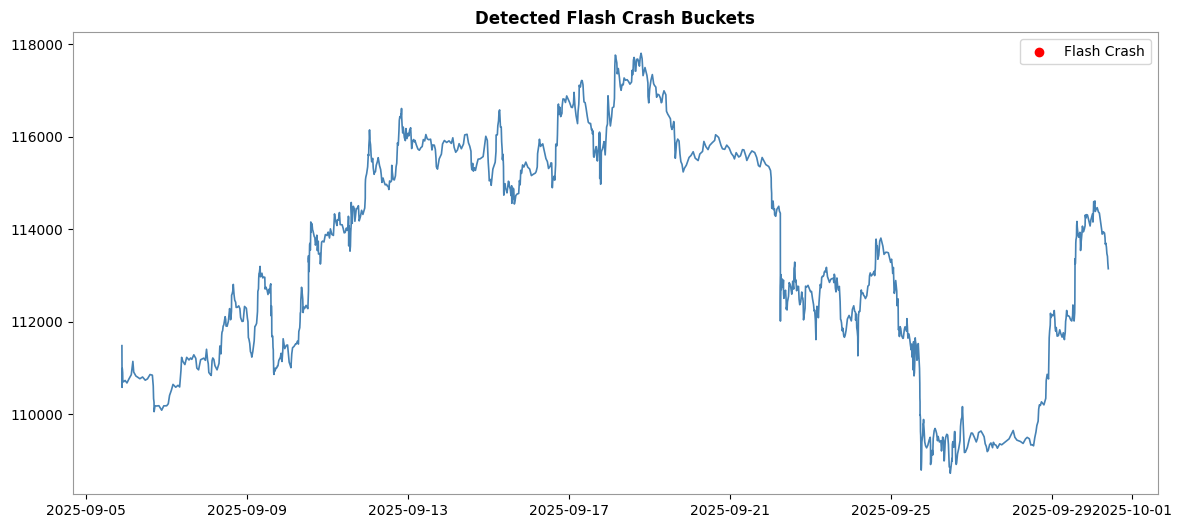

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(x['Time'], x['Price'], color='steelblue', lw=1.2)
plt.scatter(x.loc[x['is_flash']==1, 'Time'], 
            x.loc[x['is_flash']==1, 'Price'], 
            color='red', label='Flash Crash', zorder=5)
plt.legend(); plt.title('Detected Flash Crash Buckets')
plt.show()
